In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import copy
import math
import random
import time
import graphviz
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

In [2]:
data = pd.read_csv('train_clean.csv', index_col=0)
y = data['Survived'].copy()
X = data.drop(['PassengerId', 'Survived', 'Name'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=111)
X_train.shape, X_test.shape

((623, 9), (268, 9))

In [3]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
680,3,female,0.0,0,0,330935,8.1375,Unknown,Q
810,3,male,26.0,0,0,3474,7.8875,Unknown,S
727,3,female,0.0,0,0,36866,7.7375,Unknown,Q
775,3,male,18.0,0,0,347078,7.7500,Unknown,S
795,2,male,39.0,0,0,28213,13.0000,Unknown,S


In [4]:
def safeLog(x):
    if x == 0:
        return math.log(0.1)
    else:
        return math.log(x)

In [5]:
X_train['Age'].max()

71.0

In [6]:
def metric1(x1, x2, params):
    distance = 0
    #Pclass
    distance += abs(x1[0] - x2[0])/ 2
    #Sex
    distance += (x1[1] != x2[1]) * params[0]
    #Age
    if (x1[2] * x2[2] == 0) & (x1[2] != x2[2]):
        distance += params[1]
    else:
        distance += (abs(x1[2] - x2[2])/71.0) 
    #SibSp
    if x1[3] == x2[3]:
        pass
    elif x1[3] * x2[3] == 0:
        distance += 1
    else:
        distance += 0.75
    #Parch
    if x1[4] == x2[4]:
        pass
    elif x1[4] * x2[4] == 0:
        distance += 1
    else:
        distance += abs(x1[4] - x2[4]) / params[2]
    #Ticket
    distance += (x1[5] != x2[5]) 
    #Fare
    distance += abs(safeLog(x1[6] + 1) - safeLog(x2[6] + 1))/params[3]
    #Cabin
    if (x1[7] != x2[7]):
        distance += 1
    elif x1[7] == 0:
        distance += 0.3
    #Embarked
    distance += (x1[5] != x2[5])/100.0
    return distance
    

In [7]:
X_train.tail(5)

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
437,2,female,24.0,2,3,29106,18.7500,Unknown,S
36,3,male,0.0,0,0,2677,7.2292,Unknown,C
692,3,male,0.0,0,0,1601,56.4958,Unknown,S
215,1,female,31.0,1,0,35273,113.2750,D36,C
809,1,female,33.0,1,0,113806,53.1000,E8,S


In [8]:
def cabinToNumber(cabin):
    if cabin == 'Unknown':
        return 0
    else:
        return hash(cabin)

def toNumbers(data):
    X = data.copy()
    X['Sex'] = X['Sex'] == 'female'
    X['Ticket'] = X['Ticket'].apply(hash)
    X['Cabin'] = X['Cabin'].apply(cabinToNumber)
    X['Embarked'] = X['Embarked'].apply(ord)
    return X
    

In [9]:
X1_train = toNumbers(X_train)
X1_test = toNumbers(X_test)
X1_train.tail()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
437,2,True,24.0,2,3,-2970430104413268998,18.7500,0,83
36,3,False,0.0,0,0,-1746458670856982784,7.2292,0,67
692,3,False,0.0,0,0,7778026337302558711,56.4958,0,83
215,1,True,31.0,1,0,-4898068235282573226,113.2750,1268327419948972662,67
809,1,True,33.0,1,0,8856170076678879044,53.1000,5180337183469384872,83


In [10]:
clf = KNeighborsClassifier(n_neighbors=9, algorithm='brute', metric=lambda a,b: metric1(a,b,[5.0, 0.1, 10.0, 3.0]))
clf.fit(X1_train, y_train)
clf.score(X1_test, y_test)

0.8134328358208955

In [11]:
y_pred = clf.predict(X1_test)

In [12]:
y_proba = clf.predict_proba(X1_test)
y_proba[:5]

array([[0.88888889, 0.11111111],
       [0.88888889, 0.11111111],
       [0.44444444, 0.55555556],
       [1.        , 0.        ],
       [0.        , 1.        ]])

In [13]:
metricParams = []
for a in range(5,6):
    for b in [0.1]:
        for c in range(10,12,5):
            for d in range(3, 4):
                metricParams.append(lambda x1,x2: metric1(x1, x2, [a, b, c, d]))

In [14]:
start = time.clock()
knn = KNeighborsClassifier(algorithm='brute')
parameters ={'n_neighbors': range(9,15), 'weights': ['uniform', 'distance'], 'metric': metricParams}
clf1 = GridSearchCV(knn, parameters, cv=5)
clf1.fit(X1_train, y_train)
means = clf1.cv_results_['mean_test_score']
stds = clf1.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf1.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print('Best parameters:', clf1.best_params_)
print(clf1.best_score_, accuracy_score(y_test, clf1.predict(X1_test)))
print('time spent: %.2f minutes' % ((time.clock() - start)/60))

0.795 (+/-0.065) for {'metric': <function <lambda> at 0x10ea1c488>, 'n_neighbors': 9, 'weights': 'uniform'}
0.804 (+/-0.058) for {'metric': <function <lambda> at 0x10ea1c488>, 'n_neighbors': 9, 'weights': 'distance'}
0.803 (+/-0.061) for {'metric': <function <lambda> at 0x10ea1c488>, 'n_neighbors': 10, 'weights': 'uniform'}
0.801 (+/-0.079) for {'metric': <function <lambda> at 0x10ea1c488>, 'n_neighbors': 10, 'weights': 'distance'}
0.801 (+/-0.077) for {'metric': <function <lambda> at 0x10ea1c488>, 'n_neighbors': 11, 'weights': 'uniform'}
0.811 (+/-0.075) for {'metric': <function <lambda> at 0x10ea1c488>, 'n_neighbors': 11, 'weights': 'distance'}
0.799 (+/-0.082) for {'metric': <function <lambda> at 0x10ea1c488>, 'n_neighbors': 12, 'weights': 'uniform'}
0.803 (+/-0.072) for {'metric': <function <lambda> at 0x10ea1c488>, 'n_neighbors': 12, 'weights': 'distance'}
0.799 (+/-0.086) for {'metric': <function <lambda> at 0x10ea1c488>, 'n_neighbors': 13, 'weights': 'uniform'}
0.804 (+/-0.086) 

In [15]:
knn_proba = clf1.predict_proba(X1_test)
type(knn_proba)

numpy.ndarray

In [16]:
knn_proba[:5]

array([[0.91112552, 0.08887448],
       [0.8171034 , 0.1828966 ],
       [0.44709103, 0.55290897],
       [1.        , 0.        ],
       [0.        , 1.        ]])

## Different metric 

In [17]:
def metric2(x1, x2, params):
    distance = 0
    #Pclass
    distance += abs(x1[0] - x2[0])/ 2
    #Sex
    distance += (x1[1] != x2[1]) * params[0]
    #Age
    if (x1[2] * x2[2] == 0) & (x1[2] != x2[2]):
        distance += params[1]
    else:
        distance += (abs(x1[2] - x2[2])/71.0) 
    #ifChild
    if (((x1[2] > 0) & (x1[2] < 11)) & ((x2[2] == 0) | (x2[2] >= 11)) | 
       ((x2[2] > 0) & (x2[2] < 11)) & ((x1[2] == 0) | (x1[2] >= 11))):
        distance += 3
    
    #SibSp
    if x1[3] == x2[3]:
        pass
    elif x1[3] * x2[3] == 0:
        distance += 1
    else:
        distance += 0.75
    #Parch
    if x1[4] == x2[4]:
        pass
    elif x1[4] * x2[4] == 0:
        distance += 1
    else:
        distance += abs(x1[4] - x2[4]) / params[2]
    #Ticket
    distance += (x1[5] != x2[5]) 
    #Fare
    distance += abs(safeLog(x1[6] + 1) - safeLog(x2[6] + 1))/params[3]
    #Cabin
    if (x1[7] != x2[7]):
        distance += 1
    elif x1[7] == 0:
        distance += 0.3
    #Embarked
    #distance += (x1[5] != x2[5])/100.0
    return distance

In [18]:
clf2 = KNeighborsClassifier(n_neighbors=11, weights='distance', algorithm='brute', metric=lambda a,b: metric2(a,b,[5.0, 0.1, 10.0, 3.0]))
clf2.fit(X1_train, y_train)
clf2.score(X1_test, y_test)

0.7947761194029851

In [35]:
start = time.clock()
metricParams = [lambda a,b: metric1(a,b,[5.0, 0.1, 10.0, 3.0])]
knn = KNeighborsClassifier(algorithm='brute', metric=lambda a,b: metric2(a,b,[5.0, 0.1, 10.0, 3.0]))
parameters ={'n_neighbors': range(9,14), 'weights': ['uniform', 'distance']}
clf3 = GridSearchCV(knn, parameters, cv=5)
clf3.fit(X1_train, y_train)
means = clf3.cv_results_['mean_test_score']
stds = clf3.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf3.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print('Best parameters:', clf3.best_params_)
print(clf3.best_score_, accuracy_score(y_test, clf3.predict(X1_test)))
print('time spent: %.2f minutes' % ((time.clock() - start)/60))

0.809 (+/-0.071) for {'n_neighbors': 9, 'weights': 'uniform'}
0.815 (+/-0.060) for {'n_neighbors': 9, 'weights': 'distance'}
0.814 (+/-0.087) for {'n_neighbors': 10, 'weights': 'uniform'}
0.820 (+/-0.079) for {'n_neighbors': 10, 'weights': 'distance'}
0.806 (+/-0.078) for {'n_neighbors': 11, 'weights': 'uniform'}
0.822 (+/-0.073) for {'n_neighbors': 11, 'weights': 'distance'}
0.804 (+/-0.078) for {'n_neighbors': 12, 'weights': 'uniform'}
0.809 (+/-0.093) for {'n_neighbors': 12, 'weights': 'distance'}
0.799 (+/-0.076) for {'n_neighbors': 13, 'weights': 'uniform'}
0.815 (+/-0.067) for {'n_neighbors': 13, 'weights': 'distance'}
Best parameters: {'n_neighbors': 11, 'weights': 'distance'}
0.8218298555377207 0.7947761194029851
time spent: 4.66 minutes


## Split the data

In [17]:
XY_train = X1_train.copy()
XY_train['y'] = y_train
XY_test = X1_test.copy()
XY_test['y'] = y_test

In [18]:
XY_ch_train = XY_train[(XY_train['Age'] < 11) & (XY_train['Age'] > 0)].copy()
XY_ch_test = XY_test[(XY_test['Age'] < 11) & (XY_test['Age'] > 0)].copy()
XY_ad_train = XY_train[(XY_train['Age'] >= 11) | (XY_train['Age'] == 0)].copy()
XY_ad_test = XY_test[(XY_test['Age'] >= 11) | (XY_test['Age'] == 0)].copy()
XY_ch_train.shape, XY_ch_test.shape

((48, 10), (16, 10))

In [19]:
XY_f_train = XY_ad_train[XY_ad_train['Sex']].copy()
XY_f_test = XY_ad_test[XY_ad_test['Sex']].copy()
XY_m_train = XY_ad_train[XY_ad_train['Sex'] == False].copy()
XY_m_test = XY_ad_test[XY_ad_test['Sex'] == False].copy()
XY_f_train.shape, XY_f_test.shape, XY_m_train.shape, XY_m_test.shape

((195, 10), (88, 10), (380, 10), (164, 10))

In [20]:
XY_ch_train.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,y
787,3,False,8.00,4,1,1596200969129454524,29.1250,0,81,0
549,2,False,8.00,1,1,-5825690465621234393,36.7500,0,83,1
750,2,True,4.00,1,1,6861538419430179578,23.0000,0,83,1
305,1,False,0.92,1,2,3791881848988042204,151.5500,-5316271513937257180,83,1
691,3,True,4.00,0,1,5046427340628964821,13.4167,0,67,1


In [21]:
XY_ch_train.groupby(['SibSp'])['y'].count()

SibSp
0    12
1    16
2     4
3     5
4    10
5     1
Name: y, dtype: int64

In [22]:
XY_ch_train[XY_ch_train['SibSp'] > 2].groupby('Ticket').count()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,y
Ticket,,,,,,,,,
-8390409145606947083,3,3,3,3,3,3,3,3,3
-4950011229775712392,2,2,2,2,2,2,2,2,2
-3790748452038005826,3,3,3,3,3,3,3,3,3
-541997463550151252,1,1,1,1,1,1,1,1,1
982771382874576952,3,3,3,3,3,3,3,3,3
1596200969129454524,2,2,2,2,2,2,2,2,2
4347479549437982027,2,2,2,2,2,2,2,2,2


In [23]:
XY_ch_train['Fare'].min()

8.5167

In [24]:
safeLog(151)

5.017279836814924

In [25]:
def metricChild(x1, x2):
    distance = 0
    #Pclass
    distance += abs(x1[0] - x2[0])/ 2
    #Sex
    distance += (x1[1] != x2[1]) * 0.1
    #Age
    distance += (abs(x1[2] - x2[2])/10.0) 
    #SibSp
    safeLog(abs(x1[3] - x2[3]) + 1)
    #Parch
    if x1[4] != x2[4]:
        distance += 1
    #Ticket
    distance += (x1[5] != x2[5]) 
    #Fare
    distance += abs(safeLog(x1[6] + 1) - safeLog(x2[6] + 1))/2.0
    #Cabin
    if (x1[7] != x2[7]):
        distance += 1
    elif x1[7] == 0:
        distance += 0.3
    #Embarked
    #distance += (x1[5] != x2[5])/100.0
    return distance

In [26]:
y_ch_train = XY_ch_train['y']
y_ch_test = XY_ch_test['y']
X_ch_train = XY_ch_train.drop('y', axis=1)
X_ch_test = XY_ch_test.drop('y', axis=1)

In [27]:
clf_ch1 = KNeighborsClassifier(n_neighbors=11, weights='distance', algorithm='brute', metric=lambda a,b: metricChild(a,b))
clf_ch1.fit(X_ch_train, y_ch_train)
clf_ch1.score(X_ch_test, y_ch_test)

0.9375

In [28]:
start = time.clock()
knn = KNeighborsClassifier(algorithm='brute', metric=lambda a,b: metricChild(a,b))
parameters ={'n_neighbors': range(5,14), 'weights': ['uniform', 'distance']}
clf_ch = GridSearchCV(knn, parameters, cv=10)
clf_ch.fit(X_ch_train, y_ch_train)
means = clf_ch.cv_results_['mean_test_score']
stds = clf_ch.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf_ch.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print('Best parameters:', clf_ch.best_params_)
print(clf_ch.best_score_, accuracy_score(y_ch_test, clf_ch.predict(X_ch_test)))
print('time spent: %.2f minutes' % ((time.clock() - start)/60))

0.792 (+/-0.449) for {'n_neighbors': 5, 'weights': 'uniform'}
0.833 (+/-0.331) for {'n_neighbors': 5, 'weights': 'distance'}
0.729 (+/-0.380) for {'n_neighbors': 6, 'weights': 'uniform'}
0.833 (+/-0.253) for {'n_neighbors': 6, 'weights': 'distance'}
0.771 (+/-0.498) for {'n_neighbors': 7, 'weights': 'uniform'}
0.792 (+/-0.384) for {'n_neighbors': 7, 'weights': 'distance'}
0.729 (+/-0.515) for {'n_neighbors': 8, 'weights': 'uniform'}
0.792 (+/-0.425) for {'n_neighbors': 8, 'weights': 'distance'}
0.729 (+/-0.481) for {'n_neighbors': 9, 'weights': 'uniform'}
0.771 (+/-0.401) for {'n_neighbors': 9, 'weights': 'distance'}
0.750 (+/-0.413) for {'n_neighbors': 10, 'weights': 'uniform'}
0.812 (+/-0.404) for {'n_neighbors': 10, 'weights': 'distance'}
0.750 (+/-0.474) for {'n_neighbors': 11, 'weights': 'uniform'}
0.792 (+/-0.484) for {'n_neighbors': 11, 'weights': 'distance'}
0.688 (+/-0.484) for {'n_neighbors': 12, 'weights': 'uniform'}
0.771 (+/-0.498) for {'n_neighbors': 12, 'weights': 'dista

In [28]:
XY_f_train.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,y
680,3,True,0.0,0,0,-7658040212645836019,8.1375,0,81,0
727,3,True,0.0,0,0,-805423065161303625,7.7375,0,81,1
84,2,True,17.0,0,0,-5909104014021947928,10.5000,0,83,1
542,3,True,11.0,4,2,-3790748452038005826,31.2750,0,83,0
369,1,True,24.0,0,0,519670340334448164,69.3000,-1821753153063661302,67,1


In [29]:
XY_f_train.groupby(['Pclass'])['y'].mean()

Pclass
1    0.985507
2    0.883721
3    0.542169
Name: y, dtype: float64

In [30]:
XY_f_train[(XY_f_train['Pclass'] == 3)].groupby(['Parch', 'SibSp'])['y'].mean()

Parch  SibSp
0      0        0.674419
       1        0.454545
       2        0.500000
1      0        1.000000
       1        0.500000
       3        0.000000
2      0        0.600000
       1        0.000000
       4        0.500000
       8        0.000000
3      0        1.000000
       1        0.000000
4      1        0.000000
5      0        0.000000
       1        0.500000
Name: y, dtype: float64

In [31]:
def metricFemale(x1, x2):
    distance = 0
    #Pclass
    distance += abs(x1[0] - x2[0]) * 5
    #Sex
    distance += (x1[1] != x2[1])
    #Age
    distance += (abs(x1[2] - x2[2])/30.0) 
    #SibSp
    safeLog(abs(x1[3] - x2[3]) + 1)
    #Parch
    if x1[4] == x2[4]:
        pass
    elif x1[4] * x2[4] == 0:
        distance += 1
    else:
        distance += abs(x1[4] - x2[4]) / 10
    #Ticket
    distance += (x1[5] != x2[5]) 
    #Fare
    distance += abs(safeLog(x1[6] + 1) - safeLog(x2[6] + 1))/2.0
    #Cabin
    if (x1[7] != x2[7]):
        distance += 1
    elif x1[7] == 0:
        distance += 0.3
    #Embarked
    #distance += (x1[5] != x2[5])/100.0
    return distance

In [32]:
y_f_train = XY_f_train['y']
y_f_test = XY_f_test['y']
X_f_train = XY_f_train.drop('y', axis=1)
X_f_test = XY_f_test.drop('y', axis=1)

In [33]:
clf_f1 = KNeighborsClassifier(n_neighbors=3, weights='distance', algorithm='brute', metric=lambda a,b: metricFemale(a,b))
clf_f1.fit(X_f_train, y_f_train)
clf_f1.score(X_f_test, y_f_test)

0.8068181818181818

In [59]:
start = time.clock()
knn = KNeighborsClassifier(algorithm='brute', metric=lambda a,b: metricFemale(a,b))
parameters ={'n_neighbors': range(3,12), 'weights': ['uniform', 'distance']}
clf_f = GridSearchCV(knn, parameters, cv=5)
clf_f.fit(X_f_train, y_f_train)
means = clf_f.cv_results_['mean_test_score']
stds = clf_f.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf_f.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print('Best parameters:', clf_f.best_params_)
print(clf_f.best_score_, accuracy_score(y_f_test, clf_f.predict(X_f_test)))
print('time spent: %.2f minutes' % ((time.clock() - start)/60))

0.836 (+/-0.065) for {'n_neighbors': 3, 'weights': 'uniform'}
0.836 (+/-0.065) for {'n_neighbors': 3, 'weights': 'distance'}
0.815 (+/-0.106) for {'n_neighbors': 4, 'weights': 'uniform'}
0.841 (+/-0.078) for {'n_neighbors': 4, 'weights': 'distance'}
0.831 (+/-0.049) for {'n_neighbors': 5, 'weights': 'uniform'}
0.831 (+/-0.049) for {'n_neighbors': 5, 'weights': 'distance'}
0.826 (+/-0.115) for {'n_neighbors': 6, 'weights': 'uniform'}
0.846 (+/-0.104) for {'n_neighbors': 6, 'weights': 'distance'}
0.836 (+/-0.066) for {'n_neighbors': 7, 'weights': 'uniform'}
0.836 (+/-0.066) for {'n_neighbors': 7, 'weights': 'distance'}
0.846 (+/-0.083) for {'n_neighbors': 8, 'weights': 'uniform'}
0.851 (+/-0.091) for {'n_neighbors': 8, 'weights': 'distance'}
0.831 (+/-0.108) for {'n_neighbors': 9, 'weights': 'uniform'}
0.831 (+/-0.108) for {'n_neighbors': 9, 'weights': 'distance'}
0.836 (+/-0.087) for {'n_neighbors': 10, 'weights': 'uniform'}
0.836 (+/-0.087) for {'n_neighbors': 10, 'weights': 'distance'

In [45]:
start = time.clock()
knn = KNeighborsClassifier(algorithm='brute', metric=lambda a,b: metricFemale(a,b))
rf = RandomForestClassifier(n_estimators=500, max_features='sqrt')
parameters ={'max_depth': range(3,8), 'min_samples_split' : range(5,21,2), 'min_impurity_decrease': [0.002, 0.003]}
clf_f_rf = GridSearchCV(rf, parameters, cv=5)
clf_f_rf.fit(X_f_train, y_f_train)
means = clf_f_rf.cv_results_['mean_test_score']
stds = clf_f_rf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf_f_rf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print('Best parameters:', clf_f_rf.best_params_)
print(clf_f_rf.best_score_, accuracy_score(y_f_test, clf_f_rf.predict(X_f_test)))
print('time spent: %.2f minutes' % ((time.clock() - start)/60))

0.815 (+/-0.049) for {'max_depth': 3, 'min_impurity_decrease': 0.002, 'min_samples_split': 5}
0.805 (+/-0.049) for {'max_depth': 3, 'min_impurity_decrease': 0.002, 'min_samples_split': 7}
0.815 (+/-0.060) for {'max_depth': 3, 'min_impurity_decrease': 0.002, 'min_samples_split': 9}
0.810 (+/-0.051) for {'max_depth': 3, 'min_impurity_decrease': 0.002, 'min_samples_split': 11}
0.805 (+/-0.049) for {'max_depth': 3, 'min_impurity_decrease': 0.002, 'min_samples_split': 13}
0.810 (+/-0.051) for {'max_depth': 3, 'min_impurity_decrease': 0.002, 'min_samples_split': 15}
0.805 (+/-0.049) for {'max_depth': 3, 'min_impurity_decrease': 0.002, 'min_samples_split': 17}
0.805 (+/-0.049) for {'max_depth': 3, 'min_impurity_decrease': 0.002, 'min_samples_split': 19}
0.815 (+/-0.049) for {'max_depth': 3, 'min_impurity_decrease': 0.003, 'min_samples_split': 5}
0.810 (+/-0.049) for {'max_depth': 3, 'min_impurity_decrease': 0.003, 'min_samples_split': 7}
0.815 (+/-0.049) for {'max_depth': 3, 'min_impurity_dec

In [34]:
y_m_train = XY_m_train['y']
y_m_test = XY_m_test['y']
X_m_train = XY_m_train.drop('y', axis=1)
X_m_test = XY_m_test.drop('y', axis=1)

In [35]:
XY_m_train.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,y
810,3,False,26.0,0,0,4037456238788204363,7.8875,0,83,0
775,3,False,18.0,0,0,-6202714938542884908,7.7500,0,83,0
795,2,False,39.0,0,0,5013095912883230653,13.0000,0,83,0
845,3,False,42.0,0,0,-951420304713922851,7.5500,0,83,0
857,1,False,51.0,0,0,-2610761685358688808,26.5500,-2462281457472562971,83,1


In [36]:
XY_m_train.groupby(['Pclass', 'Parch', 'SibSp'])['y'].mean()

Pclass  Parch  SibSp
1       0      0        0.326531
               1        0.437500
               2        0.500000
        1      0        0.166667
               1        0.500000
        2      0        0.000000
               1        1.000000
               3        0.000000
        4      1        0.000000
2       0      0        0.096154
               1        0.111111
               2        0.000000
        1      0        0.000000
               1        0.000000
        2      0        0.000000
               1        0.000000
3       0      0        0.111111
               1        0.125000
               2        0.000000
        1      1        0.125000
               3        0.000000
               4        0.000000
        2      0        0.000000
               1        0.000000
               5        0.000000
               8        0.000000
        4      1        0.000000
        5      1        0.000000
Name: y, dtype: float64

In [37]:
def metricMale(x1, x2):
    distance = 0
    #Pclass
    distance += abs(x1[0] - x2[0]) * 2
    #Sex
    distance += (x1[1] != x2[1])
    #Age
    distance += (abs(x1[2] - x2[2])/50.0) 
    #SibSp
    safeLog(abs(x1[3] - x2[3]) + 1)
    #Parch
    if x1[4] == x2[4]:
        pass
    elif x1[4] * x2[4] == 0:
        distance += 1
    else:
        distance += abs(x1[4] - x2[4]) / 10
    #Ticket
    distance += (x1[5] != x2[5]) 
    #Fare
    distance += abs(safeLog(x1[6] + 1) - safeLog(x2[6] + 1))/3.0
    #Cabin
    if (x1[7] != x2[7]):
        distance += 1
    elif x1[7] == 0:
        distance += 0.3
    #Embarked
    #distance += (x1[5] != x2[5])/100.0
    return distance

In [38]:
clf_m1 = KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='brute', metric=lambda a,b: metricMale(a,b))
clf_m1.fit(X_m_train, y_m_train)
clf_m1.score(X_m_test, y_m_test)

0.8109756097560976

In [40]:
start = time.clock()
knn = KNeighborsClassifier(algorithm='brute', metric=lambda a,b: metricMale(a,b))
parameters ={'n_neighbors': range(3,12), 'weights': ['uniform', 'distance']}
clf_m = GridSearchCV(knn, parameters, cv=5)
clf_m.fit(X_m_train, y_m_train)
means = clf_m.cv_results_['mean_test_score']
stds = clf_m.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf_m.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print('Best parameters:', clf_m.best_params_)
print(clf_m.best_score_, accuracy_score(y_m_test, clf_m.predict(X_m_test)))
print('time spent: %.2f minutes' % ((time.clock() - start)/60))

0.803 (+/-0.053) for {'n_neighbors': 3, 'weights': 'uniform'}
0.808 (+/-0.050) for {'n_neighbors': 3, 'weights': 'distance'}
0.832 (+/-0.032) for {'n_neighbors': 4, 'weights': 'uniform'}
0.808 (+/-0.050) for {'n_neighbors': 4, 'weights': 'distance'}
0.824 (+/-0.043) for {'n_neighbors': 5, 'weights': 'uniform'}
0.824 (+/-0.049) for {'n_neighbors': 5, 'weights': 'distance'}
0.834 (+/-0.023) for {'n_neighbors': 6, 'weights': 'uniform'}
0.821 (+/-0.039) for {'n_neighbors': 6, 'weights': 'distance'}
0.826 (+/-0.023) for {'n_neighbors': 7, 'weights': 'uniform'}
0.832 (+/-0.022) for {'n_neighbors': 7, 'weights': 'distance'}
0.834 (+/-0.015) for {'n_neighbors': 8, 'weights': 'uniform'}
0.832 (+/-0.027) for {'n_neighbors': 8, 'weights': 'distance'}
0.826 (+/-0.033) for {'n_neighbors': 9, 'weights': 'uniform'}
0.832 (+/-0.027) for {'n_neighbors': 9, 'weights': 'distance'}
0.839 (+/-0.020) for {'n_neighbors': 10, 'weights': 'uniform'}
0.837 (+/-0.022) for {'n_neighbors': 10, 'weights': 'distance'

In [41]:
y_m_pred = clf_m.predict(X_m_test)
y_m_pred_1 = clf_m1.predict(X_m_test)

In [42]:
XY_m_test['y_pred'] = y_m_pred
XY_m_test['y_pred1'] = y_m_pred_1
XY_m_test['y_pred_class'] = (XY_m_test['Pclass'] == 1) & (XY_m_test['SibSp'] <= 1)
XY_m_test.groupby('y')['y_pred', 'y_pred1', 'y_pred_class'].mean()

,y_pred,y_pred1,y_pred_class
y,,,
0,0.015152,0.037879,0.181818
1,0.093750,0.187500,0.468750


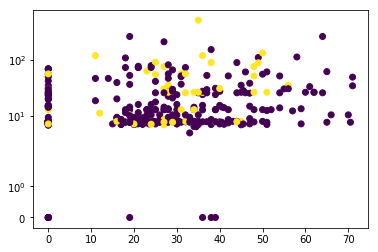

In [43]:
plt.scatter(XY_m_train['Age'], XY_m_train['Fare'], c=y_m_train)
plt.yscale('symlog')

In [44]:
XY_m_1_train = XY_m_train[XY_m_train['Pclass'] == 1].copy()
XY_m_1_test = XY_m_test[XY_m_test['Pclass'] == 1].copy()
y_m_1_train = XY_m_1_train['y']
y_m_1_test = XY_m_1_test['y']
X_m_1_train = XY_m_1_train.drop('y', axis=1)
X_m_1_test = XY_m_1_test.drop(['y', 'y_pred', 'y_pred1', 'y_pred_class'], axis=1)
XY_m_1_train.shape, XY_m_1_test.shape

((81, 10), (39, 13))

In [45]:
clf_m11 = KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='brute', metric=lambda a,b: metricMale(a,b))
clf_m11.fit(X_m_1_train, y_m_1_train)
y_m1_pred = clf_m11.predict(X_m_1_test)
clf_m11.score(X_m_1_test, y_m_1_test)

0.6153846153846154

In [46]:
start = time.clock()
knn = KNeighborsClassifier(algorithm='brute', metric=lambda a,b: metricMale(a,b))
parameters ={'n_neighbors': range(3,12), 'weights': ['uniform', 'distance']}
clf_m_1 = GridSearchCV(knn, parameters, cv=5)
clf_m_1.fit(X_m_1_train, y_m_1_train)
means = clf_m_1.cv_results_['mean_test_score']
stds = clf_m_1.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf_m_1.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print('Best parameters:', clf_m_1.best_params_)
print(clf_m_1.best_score_, accuracy_score(y_m_1_test, clf_m_1.predict(X_m_1_test)))
print('time spent: %.2f minutes' % ((time.clock() - start)/60))

0.580 (+/-0.174) for {'n_neighbors': 3, 'weights': 'uniform'}
0.605 (+/-0.188) for {'n_neighbors': 3, 'weights': 'distance'}
0.605 (+/-0.190) for {'n_neighbors': 4, 'weights': 'uniform'}
0.617 (+/-0.218) for {'n_neighbors': 4, 'weights': 'distance'}
0.556 (+/-0.149) for {'n_neighbors': 5, 'weights': 'uniform'}
0.580 (+/-0.179) for {'n_neighbors': 5, 'weights': 'distance'}
0.642 (+/-0.078) for {'n_neighbors': 6, 'weights': 'uniform'}
0.593 (+/-0.202) for {'n_neighbors': 6, 'weights': 'distance'}
0.605 (+/-0.156) for {'n_neighbors': 7, 'weights': 'uniform'}
0.642 (+/-0.151) for {'n_neighbors': 7, 'weights': 'distance'}
0.642 (+/-0.087) for {'n_neighbors': 8, 'weights': 'uniform'}
0.691 (+/-0.147) for {'n_neighbors': 8, 'weights': 'distance'}
0.580 (+/-0.181) for {'n_neighbors': 9, 'weights': 'uniform'}
0.593 (+/-0.155) for {'n_neighbors': 9, 'weights': 'distance'}
0.630 (+/-0.169) for {'n_neighbors': 10, 'weights': 'uniform'}
0.630 (+/-0.248) for {'n_neighbors': 10, 'weights': 'distance'